In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline
import requests
import json
from urllib.request import urlretrieve
from bs4 import BeautifulSoup
from collections import defaultdict

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
earthquakes = pd.read_csv('../data/earthquakes_wikitable.csv')
earthquakes

,origin_utc,date_ymd,time,country,lat,long,depth_km,magnitude,magnitude_num,secondary_effects,pde_shaking_deaths,pde_total_deaths,utsu_total_deaths,em_dat_total_deaths,other_source_deaths,other_source_deaths_new,osd1,osd2,osd3,max_deaths
0,1900-05-11 17:23,1900-05-11,17:23,Japan,38.700,141.100,5.0,7.0 MJMA,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25,1900-07-12,06:25,Turkey,40.300,43.100,NaN,5.9 Muk,5.9,NaN,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,NaN,140.0
2,1900-10-29 09:11,1900-10-29,09:11,Venezuela,11.000,-66.000,0.0,7.7 Mw,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00,1901-02-15,00:00,China,26.000,100.100,0.0,6.5 Ms,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11,1901-03-31,07:11,Bulgaria,43.400,28.700,NaN,6.4 Muk,6.4,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,2011-03-24 20:25,2011-03-24,20:25,Burma (see 2011 Burma earthquake),NaN,NaN,NaN,6.8 Mw,6.8,NaN,NaN,NaN,NaN,NaN,150,150.0,150.0,NaN,NaN,150.0
1336,2011-04-07 14:32,2011-04-07,14:32,Japan (see April 2011 Miyagi earthquake),38.2,140.0,66.0,7.1 Mw,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1337,2011-09-18 12:40,2011-09-18,12:40,India (see 2011 Sikkim earthquake),27.723,88.064,19.7,6.9 Mw,6.9,L,NaN,NaN,NaN,NaN,111,111.0,111.0,NaN,NaN,111.0
1338,2011-09-23 10:41,2011-09-23,10:41,Turkey (see 2011 Van earthquake),38.6,43.5,7.2,7.1 Mw,7.1,NaN,NaN,NaN,NaN,NaN,601,601.0,601.0,NaN,NaN,601.0


In [5]:
earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   origin_utc               1340 non-null   object 
 1   date_ymd                 1340 non-null   object 
 2   time                     1332 non-null   object 
 3   country                  1340 non-null   object 
 4   lat                      1325 non-null   object 
 5   long                     1325 non-null   object 
 6   depth_km                 1249 non-null   float64
 7   magnitude                1339 non-null   object 
 8   magnitude_num            1338 non-null   float64
 9   secondary_effects        373 non-null    object 
 10  pde_shaking_deaths       738 non-null    float64
 11  pde_total_deaths         749 non-null    float64
 12  utsu_total_deaths        1027 non-null   float64
 13  em_dat_total_deaths      559 non-null    float64
 14  other_source_deaths     

In [6]:
# Get rid of ? marks in lat and long columns
earthquakes.lat = earthquakes.lat.str.replace(r'(\?)', '')
earthquakes.long = earthquakes.long.str.replace(r'(\?)', '')

In [7]:
# change lat and long to a float
earthquakes['lat'] = pd.to_numeric(earthquakes['lat'])
earthquakes['long'] = pd.to_numeric(earthquakes['long'])
earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   origin_utc               1340 non-null   object 
 1   date_ymd                 1340 non-null   object 
 2   time                     1332 non-null   object 
 3   country                  1340 non-null   object 
 4   lat                      1324 non-null   float64
 5   long                     1324 non-null   float64
 6   depth_km                 1249 non-null   float64
 7   magnitude                1339 non-null   object 
 8   magnitude_num            1338 non-null   float64
 9   secondary_effects        373 non-null    object 
 10  pde_shaking_deaths       738 non-null    float64
 11  pde_total_deaths         749 non-null    float64
 12  utsu_total_deaths        1027 non-null   float64
 13  em_dat_total_deaths      559 non-null    float64
 14  other_source_deaths     

In [ ]:
#earthquakes['time'] = pd.to_datetime(earthquakes['time'])
#earthquakes.info()

In [10]:
earthquakes.corr(method='pearson')

,lat,long,depth_km,magnitude_num,pde_shaking_deaths,pde_total_deaths,utsu_total_deaths,em_dat_total_deaths,other_source_deaths_new,osd1,osd2,osd3,max_deaths
lat,1.000000,0.209014,-0.134188,-0.196325,0.044821,0.023187,0.050739,0.075534,-0.289499,-0.272318,-1.0,NaN,0.033332
long,0.209014,1.000000,-0.035842,0.012348,0.043549,0.046250,0.048716,0.068568,0.090938,0.074005,1.0,NaN,0.038276
depth_km,-0.134188,-0.035842,1.000000,0.164748,-0.015792,-0.011442,-0.022681,-0.024908,0.189265,0.172676,1.0,NaN,-0.022377
magnitude_num,-0.196325,0.012348,0.164748,1.000000,0.085692,0.128050,0.154792,0.222803,0.448148,0.427166,1.0,NaN,0.139651
pde_shaking_deaths,0.044821,0.043549,-0.015792,0.085692,1.000000,0.994107,0.954850,0.924447,0.764003,0.764003,NaN,NaN,0.993060
pde_total_deaths,0.023187,0.046250,-0.011442,0.128050,0.994107,1.000000,0.977493,0.949703,0.999928,0.999959,1.0,NaN,0.999791
utsu_total_deaths,0.050739,0.048716,-0.022681,0.154792,0.954850,0.977493,1.000000,0.924472,0.950601,0.950601,NaN,NaN,0.893445
em_dat_total_deaths,0.075534,0.068568,-0.024908,0.222803,0.924447,0.949703,0.924472,1.000000,0.943598,0.943598,NaN,NaN,0.901092
other_source_deaths_new,-0.289499,0.090938,0.189265,0.448148,0.764003,0.999928,0.950601,0.943598,1.000000,0.994342,1.0,NaN,0.995670
osd1,-0.272318,0.074005,0.172676,0.427166,0.764003,0.999959,0.950601,0.943598,0.994342,1.000000,1.0,NaN,0.990688


In [11]:
earthquakes.corr(method='spearman')

,lat,long,depth_km,magnitude_num,pde_shaking_deaths,pde_total_deaths,utsu_total_deaths,em_dat_total_deaths,other_source_deaths_new,osd1,osd2,osd3,max_deaths
lat,1.000000,0.045764,-0.233119,-0.214101,0.012590,-0.052686,0.052818,0.032379,-0.187424,-0.187424,-1.0,NaN,0.036799
long,0.045764,1.000000,0.001932,0.083869,0.015012,0.023963,0.037509,-0.034097,0.365690,0.365690,1.0,NaN,0.011876
depth_km,-0.233119,0.001932,1.000000,0.180134,-0.068437,-0.060439,-0.114133,-0.112001,-0.064977,-0.064977,1.0,NaN,-0.109498
magnitude_num,-0.214101,0.083869,0.180134,1.000000,0.384963,0.396071,0.378060,0.459604,0.608269,0.608269,1.0,NaN,0.419524
pde_shaking_deaths,0.012590,0.015012,-0.068437,0.384963,1.000000,0.859650,0.877777,0.899291,0.800000,0.800000,NaN,NaN,0.826476
pde_total_deaths,-0.052686,0.023963,-0.060439,0.396071,0.859650,1.000000,0.968480,0.948049,0.900000,0.900000,1.0,NaN,0.955864
utsu_total_deaths,0.052818,0.037509,-0.114133,0.378060,0.877777,0.968480,1.000000,0.955524,1.000000,1.000000,NaN,NaN,0.989543
em_dat_total_deaths,0.032379,-0.034097,-0.112001,0.459604,0.899291,0.948049,0.955524,1.000000,0.885714,0.885714,NaN,NaN,0.974755
other_source_deaths_new,-0.187424,0.365690,-0.064977,0.608269,0.800000,0.900000,1.000000,0.885714,1.000000,1.000000,1.0,NaN,0.994722
osd1,-0.187424,0.365690,-0.064977,0.608269,0.800000,0.900000,1.000000,0.885714,1.000000,1.000000,1.0,NaN,0.994722


### Thoughts?  

* The correlations between max_deaths and all other factors are pretty weak when using a Pearson's r; they're slightly stronger with Spearman's r (so we may not be working with a normal distribution) 
* There's small to moderate relationship between magnitude and other source deaths (r=0.99) 
* There's a small to moderate relationship between magnitude and max_deaths (r=0.42)
* Depth (km) has a weak negative correlation with max deaths (r=-0.11)

These are interesting findings, and slightly different from what we would expect. Let's read in some other data to tell us something useful for how we go about analyzing earthquake data and proposing emergency response plans.

In [12]:
earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   origin_utc               1340 non-null   object 
 1   date_ymd                 1340 non-null   object 
 2   time                     1332 non-null   object 
 3   country                  1340 non-null   object 
 4   lat                      1324 non-null   float64
 5   long                     1324 non-null   float64
 6   depth_km                 1249 non-null   float64
 7   magnitude                1339 non-null   object 
 8   magnitude_num            1338 non-null   float64
 9   secondary_effects        373 non-null    object 
 10  pde_shaking_deaths       738 non-null    float64
 11  pde_total_deaths         749 non-null    float64
 12  utsu_total_deaths        1027 non-null   float64
 13  em_dat_total_deaths      559 non-null    float64
 14  other_source_deaths     

In [13]:
earthquakes.tail()

,origin_utc,date_ymd,time,country,lat,long,depth_km,magnitude,magnitude_num,secondary_effects,pde_shaking_deaths,pde_total_deaths,utsu_total_deaths,em_dat_total_deaths,other_source_deaths,other_source_deaths_new,osd1,osd2,osd3,max_deaths
1335,2011-03-24 20:25,2011-03-24,20:25,Burma (see 2011 Burma earthquake),NaN,NaN,NaN,6.8 Mw,6.8,NaN,NaN,NaN,NaN,NaN,150,150.0,150.0,NaN,NaN,150.0
1336,2011-04-07 14:32,2011-04-07,14:32,Japan (see April 2011 Miyagi earthquake),38.200,140.000,66.0,7.1 Mw,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1337,2011-09-18 12:40,2011-09-18,12:40,India (see 2011 Sikkim earthquake),27.723,88.064,19.7,6.9 Mw,6.9,L,NaN,NaN,NaN,NaN,111,111.0,111.0,NaN,NaN,111.0
1338,2011-09-23 10:41,2011-09-23,10:41,Turkey (see 2011 Van earthquake),38.600,43.500,7.2,7.1 Mw,7.1,NaN,NaN,NaN,NaN,NaN,601,601.0,601.0,NaN,NaN,601.0
1339,2018-08-05 19:46,2018-08-05,19:46,Indonesia (see Lombok earthquake),NaN,NaN,31.0,6.9 Mw,6.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Extract year into separate column for merge
earthquakes['year'] = earthquakes['date_ymd'].str.extract('(\d{4})')
earthquakes['year']

0       1900
1       1900
2       1900
3       1901
4       1901
        ... 
1335    2011
1336    2011
1337    2011
1338    2011
1339    2018
Name: year, Length: 1340, dtype: object

In [15]:
# rename country column for merge
earthquakes.columns = ['origin_utc', 'date_ymd', 'time', 'country_old', 'lat', 'long', 'depth_km', 'magnitude', 'magnitude_num', 'secondary_effects', 'pde_shaking_deaths', 'pde_total_deaths', 'utsu_total_deaths', 'em_dat_total_deaths', 'other_source_deaths', 'other_source_deaths_new', 'osd1', 'osd2', 'osd3', 'max_deaths', 'year']

In [16]:
# clean up country info...there are too many values that have extra information in parentheses
earthquakes['country'] = earthquakes['country_old'].str.extract('(^\w+)')
earthquakes['country']

0           Japan
1          Turkey
2       Venezuela
3           China
4        Bulgaria
          ...    
1335        Burma
1336        Japan
1337        India
1338       Turkey
1339    Indonesia
Name: country, Length: 1340, dtype: object

In [17]:
earthquakes['country'].unique()

array(['Japan', 'Turkey', 'Venezuela', 'China', 'Bulgaria', 'New',
       'Azerbaijan', 'Guatemala', 'Australia', 'Uzbekistan', 'Palestine',
       'Greece', 'Iran', 'Taiwan', 'India', 'Albania', 'Italy', 'Ecuador',
       'United', 'Chile', 'Indonesia', 'Jamaica', 'Mexico', 'Philippines',
       'Tajikistan', 'Portugal', 'France', 'Pakistan', 'Algeria',
       'Kazakhstan', 'Kyrgyzstan', 'Iceland', 'Burma', 'Peru', 'El',
       'Colombia', 'Russian', 'Puerto', 'Papua', 'Georgia', 'Argentina',
       'Eritrea', 'Bangladesh', 'Nicaragua', 'Mandatory', 'Turkmenistan',
       'Saint', 'Kingdom', 'Armenia', 'England', 'Solomon', 'Cuba',
       'Nepal', 'Ghana', 'Romania', 'Yemen', 'Canada', 'Dominican',
       'Tajik', 'Haiti', 'Cyprus', 'Fiji', 'Egypt', 'Costa', 'Hungary',
       'Syrian', 'Afghanistan', 'Tunisia', 'Mongolia', 'US', 'Morocco',
       'Democratic', 'Ethiopia', 'Macedonia', 'Tanzania', 'South',
       'Bosnia', 'Vanuatu', 'Panama', 'Montenegro', 'Honduras',
       'Yugoslav

In [18]:
earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   origin_utc               1340 non-null   object 
 1   date_ymd                 1340 non-null   object 
 2   time                     1332 non-null   object 
 3   country_old              1340 non-null   object 
 4   lat                      1324 non-null   float64
 5   long                     1324 non-null   float64
 6   depth_km                 1249 non-null   float64
 7   magnitude                1339 non-null   object 
 8   magnitude_num            1338 non-null   float64
 9   secondary_effects        373 non-null    object 
 10  pde_shaking_deaths       738 non-null    float64
 11  pde_total_deaths         749 non-null    float64
 12  utsu_total_deaths        1027 non-null   float64
 13  em_dat_total_deaths      559 non-null    float64
 14  other_source_deaths     

In [19]:
# change year to a float
earthquakes['year'] = pd.to_numeric(earthquakes['year'])
earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   origin_utc               1340 non-null   object 
 1   date_ymd                 1340 non-null   object 
 2   time                     1332 non-null   object 
 3   country_old              1340 non-null   object 
 4   lat                      1324 non-null   float64
 5   long                     1324 non-null   float64
 6   depth_km                 1249 non-null   float64
 7   magnitude                1339 non-null   object 
 8   magnitude_num            1338 non-null   float64
 9   secondary_effects        373 non-null    object 
 10  pde_shaking_deaths       738 non-null    float64
 11  pde_total_deaths         749 non-null    float64
 12  utsu_total_deaths        1027 non-null   float64
 13  em_dat_total_deaths      559 non-null    float64
 14  other_source_deaths     

In [20]:
# Read in gdp data
gdp_df = pd.read_csv('../data/gdp_per_capita.csv', nrows = 6729)
# Check to make sure that all rows got read in
gdp_df.tail()

,Country or Area,Year,Value,Value Footnotes
6724,Zimbabwe,1994,2768.309953,NaN
6725,Zimbabwe,1993,2572.870395,NaN
6726,Zimbabwe,1992,2591.007534,NaN
6727,Zimbabwe,1991,2906.272849,NaN
6728,Zimbabwe,1990,2819.549467,NaN


In [21]:
gdp_df = (gdp_df
          .drop(columns = 'Value Footnotes')
          .rename(columns = {'Country or Area': 'country', 'Year': 'year', 'Value': 'gdp_per_capita'})
         )

gdp_df.shape

(6729, 3)

In [22]:
gdp_df['year'] = pd.to_numeric(gdp_df['year'])
gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6729 entries, 0 to 6728
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         6729 non-null   object 
 1   year            6729 non-null   int64  
 2   gdp_per_capita  6729 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 157.8+ KB


In [ ]:
# what years are present in this dataset?
gdp_df.groupby('year')['year'].count().sort_values()

In [ ]:
# read in continents data - not necessary
# continents = pd.read_csv('../data/continents.csv')
# continents.head()

In [ ]:
# continents = continents.rename(columns = {'Continent': 'continent', 'Country': 'country'})
# continents.head()

In [23]:
# merge GDP to earthquakes
# use a left join so that all values conform to the earthquakes dataframe (or are otherwise left out)
eq_gdp = earthquakes.merge(gdp_df, on=['country', 'year'], how='left')
eq_gdp.head(20)

,origin_utc,date_ymd,time,country_old,lat,long,depth_km,magnitude,magnitude_num,secondary_effects,pde_shaking_deaths,pde_total_deaths,utsu_total_deaths,em_dat_total_deaths,other_source_deaths,other_source_deaths_new,osd1,osd2,osd3,max_deaths,year,country,gdp_per_capita
0,1900-05-11 17:23,1900-05-11,17:23,Japan,38.70,141.10,5.0,7.0 MJMA,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900,Japan,NaN
1,1900-07-12 06:25,1900-07-12,06:25,Turkey,40.30,43.10,NaN,5.9 Muk,5.9,NaN,NaN,NaN,140.0,NaN,NaN,NaN,NaN,NaN,NaN,140.0,1900,Turkey,NaN
2,1900-10-29 09:11,1900-10-29,09:11,Venezuela,11.00,-66.00,0.0,7.7 Mw,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900,Venezuela,NaN
3,1901-02-15 00:00,1901-02-15,00:00,China,26.00,100.10,0.0,6.5 Ms,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1901,China,NaN
4,1901-03-31 07:11,1901-03-31,07:11,Bulgaria,43.40,28.70,NaN,6.4 Muk,6.4,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1901,Bulgaria,NaN
5,1901-08-09 09:23,1901-08-09,09:23,Japan,40.50,142.50,35.0,7.2 Mw,7.2,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1901,Japan,NaN
6,1901-11-15 20:15,1901-11-15,20:15,New Zealand (see 1901 Cheviot earthquake),-43.00,173.00,0.0,6.8 Ms,6.8,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1901,New,NaN
7,1902-01-30 14:01,1902-01-30,14:01,Japan,40.50,141.30,35.0,6.9 Ms,6.9,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1902,Japan,NaN
8,1902-02-13 09:39,1902-02-13,09:39,Azerbaijan,40.70,48.60,15.0,6.9 Muk,6.9,NaN,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,NaN,86.0,1902,Azerbaijan,NaN
9,1902-03-09 07:46,1902-03-09,07:46,Turkey,40.70,33.60,NaN,5.5 Muk,5.5,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1902,Turkey,NaN


In [24]:
eq_gdp.tail(20)

,origin_utc,date_ymd,time,country_old,lat,long,depth_km,magnitude,magnitude_num,secondary_effects,pde_shaking_deaths,pde_total_deaths,utsu_total_deaths,em_dat_total_deaths,other_source_deaths,other_source_deaths_new,osd1,osd2,osd3,max_deaths,year,country,gdp_per_capita
1320,2009-01-08 19:21,2009-01-08,19:21,Costa Rica (see 2009 Cinchona earthquake),10.3962,-84.0281,48.0,6.1 Mw,6.1,L,NaN,NaN,NaN,NaN,34,34.0,34.0,NaN,NaN,34.0,2009,Costa,NaN
1321,2009-04-06 03:32,2009-04-06,03:32,Italy (see 2009 L'Aquila earthquake),42.3340,13.3340,8.8,6.2 Mw,6.2,NaN,NaN,NaN,NaN,NaN,295,295.0,295.0,NaN,NaN,295.0,2009,Italy,35900.578841
1322,2009-07-09 11:19,2009-07-09,11:19,China (see 2009 Yunnan earthquake),NaN,NaN,NaN,5.7 Mw,5.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,China,8626.532479
1323,2009-08-10 20:07,2009-08-10,20:07,Japan (see 2009 Shizuoka earthquake),NaN,NaN,NaN,6.4 Mw,6.4,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,NaN,NaN,1.0,2009,Japan,34317.670825
1324,2009-09-02 07:55,2009-09-02,07:55,Indonesia (see 2009 West Java earthquake),NaN,NaN,NaN,7.0 Mw,7.0,NaN,NaN,NaN,NaN,NaN,79,79.0,79.0,NaN,NaN,79.0,2009,Indonesia,8069.241897
1325,2009-09-29 17:48,2009-09-29,17:48,Samoa (see 2009 Samoa earthquake and tsunami),NaN,NaN,8.1,8.1 Mw,8.1,NaN,NaN,NaN,NaN,NaN,189,189.0,189.0,NaN,NaN,189.0,2009,Samoa,5487.968952
1326,2009-09-30 10:16,2009-09-30,10:16,Indonesia (see 2009 Padang earthquake),NaN,NaN,NaN,7.6 Mw,7.6,NaN,NaN,NaN,NaN,NaN,1115,1115.0,1115.0,NaN,NaN,1115.0,2009,Indonesia,8069.241897
1327,2010-01-12 17:00,2010-01-12,17:00,Haiti (see 2010 Haiti earthquake),18.4570,-72.5330,13.0,7.0 Mw,7.0,NaN,NaN,NaN,NaN,NaN,222517,222517.0,222517.0,NaN,NaN,222517.0,2010,Haiti,1509.625632
1328,2010-02-27 06:34,2010-02-27,06:34,Chile (see 2010 Chile earthquake),-35.8460,-72.7190,35.0,8.8 Mw [18],8.8,T,NaN,NaN,NaN,NaN,521,521.0,521.0,NaN,NaN,521.0,2010,Chile,19363.220303
1329,2010-03-08 02:32,2010-03-08,02:32,Turkey (see 2010 Elâzığ earthquake),NaN,NaN,NaN,6.1 Mw,6.1,NaN,NaN,NaN,NaN,NaN,42,42.0,42.0,NaN,NaN,42.0,2010,Turkey,17959.240722


In [25]:
# perform .corr on new dataframe
eq_gdp.corr(method='spearman')

,lat,long,depth_km,magnitude_num,pde_shaking_deaths,pde_total_deaths,utsu_total_deaths,em_dat_total_deaths,other_source_deaths_new,osd1,osd2,osd3,max_deaths,year,gdp_per_capita
lat,1.000000,0.045764,-0.233119,-0.214101,0.012590,-0.052686,0.052818,0.032379,-0.187424,-0.187424,-1.0,NaN,0.036799,-0.076173,0.219024
long,0.045764,1.000000,0.001932,0.083869,0.015012,0.023963,0.037509,-0.034097,0.365690,0.365690,1.0,NaN,0.011876,0.024814,-0.259962
depth_km,-0.233119,0.001932,1.000000,0.180134,-0.068437,-0.060439,-0.114133,-0.112001,-0.064977,-0.064977,1.0,NaN,-0.109498,0.011722,-0.069998
magnitude_num,-0.214101,0.083869,0.180134,1.000000,0.384963,0.396071,0.378060,0.459604,0.608269,0.608269,1.0,NaN,0.419524,-0.351718,0.111113
pde_shaking_deaths,0.012590,0.015012,-0.068437,0.384963,1.000000,0.859650,0.877777,0.899291,0.800000,0.800000,NaN,NaN,0.826476,-0.148445,-0.138911
pde_total_deaths,-0.052686,0.023963,-0.060439,0.396071,0.859650,1.000000,0.968480,0.948049,0.900000,0.900000,1.0,NaN,0.955864,-0.133833,-0.111248
utsu_total_deaths,0.052818,0.037509,-0.114133,0.378060,0.877777,0.968480,1.000000,0.955524,1.000000,1.000000,NaN,NaN,0.989543,-0.352989,-0.128191
em_dat_total_deaths,0.032379,-0.034097,-0.112001,0.459604,0.899291,0.948049,0.955524,1.000000,0.885714,0.885714,NaN,NaN,0.974755,-0.420716,-0.053239
other_source_deaths_new,-0.187424,0.365690,-0.064977,0.608269,0.800000,0.900000,1.000000,0.885714,1.000000,1.000000,1.0,NaN,0.994722,-0.141667,-0.206851
osd1,-0.187424,0.365690,-0.064977,0.608269,0.800000,0.900000,1.000000,0.885714,1.000000,1.000000,1.0,NaN,0.994722,-0.141667,-0.206851


In [26]:
eq_gdp.corr(method='pearson')

,lat,long,depth_km,magnitude_num,pde_shaking_deaths,pde_total_deaths,utsu_total_deaths,em_dat_total_deaths,other_source_deaths_new,osd1,osd2,osd3,max_deaths,year,gdp_per_capita
lat,1.000000,0.209014,-0.134188,-0.196325,0.044821,0.023187,0.050739,0.075534,-0.289499,-0.272318,-1.0,NaN,0.033332,-0.072883,0.257812
long,0.209014,1.000000,-0.035842,0.012348,0.043549,0.046250,0.048716,0.068568,0.090938,0.074005,1.0,NaN,0.038276,-0.003181,-0.077344
depth_km,-0.134188,-0.035842,1.000000,0.164748,-0.015792,-0.011442,-0.022681,-0.024908,0.189265,0.172676,1.0,NaN,-0.022377,0.021288,-0.033298
magnitude_num,-0.196325,0.012348,0.164748,1.000000,0.085692,0.128050,0.154792,0.222803,0.448148,0.427166,1.0,NaN,0.139651,-0.345820,0.041621
pde_shaking_deaths,0.044821,0.043549,-0.015792,0.085692,1.000000,0.994107,0.954850,0.924447,0.764003,0.764003,NaN,NaN,0.993060,-0.039812,-0.030887
pde_total_deaths,0.023187,0.046250,-0.011442,0.128050,0.994107,1.000000,0.977493,0.949703,0.999928,0.999959,1.0,NaN,0.999791,-0.024506,-0.033788
utsu_total_deaths,0.050739,0.048716,-0.022681,0.154792,0.954850,0.977493,1.000000,0.924472,0.950601,0.950601,NaN,NaN,0.893445,-0.094207,0.012751
em_dat_total_deaths,0.075534,0.068568,-0.024908,0.222803,0.924447,0.949703,0.924472,1.000000,0.943598,0.943598,NaN,NaN,0.901092,-0.230817,-0.031243
other_source_deaths_new,-0.289499,0.090938,0.189265,0.448148,0.764003,0.999928,0.950601,0.943598,1.000000,0.994342,1.0,NaN,0.995670,0.084384,-0.340066
osd1,-0.272318,0.074005,0.172676,0.427166,0.764003,0.999959,0.950601,0.943598,0.994342,1.000000,1.0,NaN,0.990688,0.078886,-0.349419


### Findings:  

* There is a weak negative correlation between max deaths and gdp per capita (r = -0.10).  
* There are lots of other confounding variables to consider here, but the trend we might be seeing is that countries with higher gdp's per capita tend to report fewer deaths following an earthquake.  
* There is a weak negative correlation between other source deaths and gdp per capita (r = -0.21).  

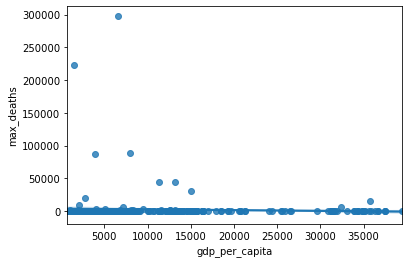

In [31]:
# Plot the relationship btwn gdp_per_capita and max_deaths (r = -0.10)
sns.regplot(x=eq_gdp['gdp_per_capita'], y=eq_gdp['max_deaths']);

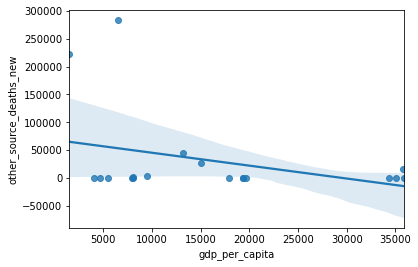

In [29]:
# Plot the relationship btwn gdp_per_capita and other source deaths (r = -0.21)
sns.regplot(x=eq_gdp['gdp_per_capita'], y=eq_gdp['other_source_deaths_new']);